# TP1: Recommendation

*By Daniel Deutsch and Kevin Kuhl*

In [48]:
import movielens_utils

from matplotlib import pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import svds
from scipy.optimize import check_grad
from numpy.linalg import norm

In [37]:
# Sets constants
rho = 0.3

# 1) Presentation of the Model

### Question 1.1

- The **minidata** argument on the load_movielens function (if True) reduces the data to a 100x200 dimension.

In [38]:
def load_movielens(filename, minidata=False):
    data = np.loadtxt(filename, dtype=int)
    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)), dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape), (data[:, 0]-1, data[:, 1]-1)), dtype=bool)
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask

In [39]:
R, mask = load_movielens("./datasets/ml-100k/u.data")
print(f"The R matrix has size {R.shape}")

The R matrix has size (943, 1682)


### Question 1.2

In [40]:
print(f"There are {R.shape[0]} users and {R.shape[1]} films in the dataset.\nThe total number of grades is {mask.sum()}.")

There are 943 users and 1682 films in the dataset.
The total number of grades is 100000.


# 2) Find $P$ when $Q^0$ is Fixed 

### Question 2.1

To find the gradient of the function $g$ we need to obtain the derivative in relation to $P$:

<br>

\begin{aligned}
    \nabla g(P) \quad = \quad \frac{\partial g}{\partial P} \quad & = \quad \frac{\partial}{\partial P} \left(\frac{1}{2} ||1_K \circ (R - Q^0 P) ||_F^2 + \frac{\rho}{2}||Q^0||_F^2 + \frac{\rho}{2} ||P||_F^2\right) \\
    & = \quad \frac{\partial}{\partial P} \left(\frac{1}{2} ||1_K \circ (R - Q^0 P) ||_F^2\right) + \underbrace{\frac{\partial}{\partial P} \left(\frac{\rho}{2}||Q^0||_F^2\right)}_\text{= 0} + \frac{\partial}{\partial P} \left(\frac{\rho}{2} ||P||_F^2\right) \\
    & = \quad \left(-\frac{2}{2} \left(Q^0\right)^T [1_K \circ (R - Q^0 P)]\right) + \left(\frac{\rho}{2} 2 P\right) \\
    & = \quad -\left(Q^0\right)^T [1_K \circ (R - Q^0 P)] + \rho P
\end{aligned}

### Question 2.2

In [41]:
def objective(P, Q0, R, mask, rho):
    tmp = (R - Q0.dot(P)) * mask
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))
    grad_P = -Q0.T.dot(tmp) + rho*P
    return val, grad_P

In [42]:
Q0, s, P0 = svds(R, k=4)

err = check_grad(
    lambda P: objective(np.reshape(P, np.shape(P0)), Q0, R, mask, rho)[0],
    lambda P: np.ravel(objective(np.reshape(P, np.shape(P0)), Q0, R, mask, rho)[1]),
    np.ravel(P0)
)
print(f"The error of the obtained gradient is: {err}")

The error of the obtained gradient is: 1.1652685524704118


### Question 2.3

In [43]:
def gradient(g, P0, gamma, epsilon):
    gradients_norm = []
    grad_g = g(P0)[1]
    Pk = P0
    while np.sum(grad_g**2) > epsilon:
        Pk = Pk - gamma*grad_g
        grad_g = g(Pk)[1]
        gradients_norm.append(np.linalg.norm(grad_g))
    plt.plot(gradients_norm)
    plt.title("Visualization of the norm of gradient along iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Norm of Gradient")
    return Pk

### Question 2.4

array([[ 2.23195586e+00, -4.90901655e-01, -9.99038902e+00, ...,
         4.74720062e-01, -3.92005611e-02, -8.67313639e-01],
       [-4.53690158e+00,  1.35383903e+01,  2.56918810e+00, ...,
        -3.63328948e-01,  3.15228411e-01,  1.77354579e-01],
       [-2.02973198e+01, -4.69295419e-01, -1.07439139e+01, ...,
        -3.43309414e-01,  8.20572197e-02,  1.54910736e-01],
       [-5.76413523e+01, -2.77434992e+01, -1.98610680e+01, ...,
        -6.08854704e-02, -6.75456877e-01, -6.32182974e-01]])

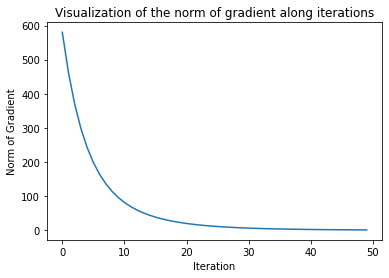

In [44]:
epsilon = 1
g = lambda P: objective(P, Q0, R, mask, rho)
L = rho + np.sum(Q0.transpose().dot(Q0)**2)

Pm = gradient(g, P0, 1/L, epsilon)
Pm

### Question 2.5

In [45]:
def gradient_linear(g, P0, epsilon):

    # Defines Armijo's linear search params
    a = 1/2          # a ∈ (0, 1)
    b = 1/4          # b > 0
    beta = 10**(-5)  # β ∈ (0, 1)
    gradients_norm = []

    grad_g = g(P0)[1]
    Pk = P0
    while norm(grad_g) > epsilon:
        l = 0
        while g(Pk-b*(a**l)*grad_g)[0] > g(Pk)[0] - beta*b*(a**l)*norm(grad_g):
            l += 1
        Pk -= b*(a**l)*grad_g
        b = 2*b*(a**l)
        grad_g = g(Pk)[1]
        gradients_norm.append(np.linalg.norm(grad_g))
        
    plt.plot(gradients_norm)
    plt.title("Visualization of the norm of gradient along iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Norm of Gradient")
    return Pk

array([[ 2.23792698e+00, -4.87938555e-01, -9.97047253e+00, ...,
         4.81437479e-01, -3.97755722e-02, -8.79465982e-01],
       [-4.53696087e+00,  1.35225369e+01,  2.55309718e+00, ...,
        -3.68473136e-01,  3.19854867e-01,  1.79841042e-01],
       [-2.03052647e+01, -4.68329945e-01, -1.07543856e+01, ...,
        -3.48170999e-01,  8.32617323e-02,  1.57082925e-01],
       [-5.76545433e+01, -2.77582457e+01, -1.98909485e+01, ...,
        -6.17484119e-02, -6.85380001e-01, -6.41055344e-01]])

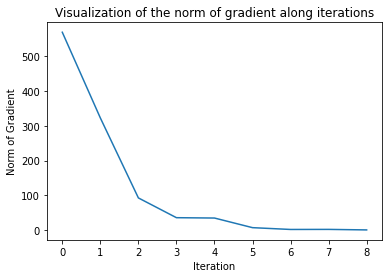

In [46]:
Pm = gradient_linear(g, P0, epsilon)
Pm

# 3) Resolution of the Full Problem

### Question 3.1

If f is a polynomial of degree 4, then its gradient is a polynomial of degree 3.

**Theorem:** *Let f: I $\rightarrow$ R be differentiable, with the property that |$\nabla f(x)$| $\leq$ M, $\forall x \in I$.*

*Then, |f(x) - f(y)| $\leq$ M|x-y|, for all x $\in$ I.*

Therefore, if $\nabla f(x)$ is Lipschitz continuous, one can use the inverse of the above theorem to imply that $\nabla^2 f(x)$ will be bounded.

If f is a polynomial of degree 4, $\nabla^2 f(x)$ is a polynomial of degree 2. Therefore, it is not bounded.

Therefore, $\nabla f(x)$ is not Lipschitz continuous.

### Question 3.2

In [50]:
def total_objective(P, Q, R, mask, rho):

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))

    grad_P = rho * P - Q.T.dot(tmp)

    grad_Q = rho * Q - tmp.dot(P.T)

    return val, grad_P, grad_Q

In [51]:
 def rechercheLineaire(g,P0,Q0,epsilon):
    P=P0
    Q=Q0
    val, grad_P,grad_Q = total_objective(P=P, Q=Q, R=R , mask=mask, rho=0.3)
    norm_grad = np.sqrt(np.sum(grad_P**2)+np.sum(grad_Q**2))
    while (norm_grad > epsilon):
        l=0
        a,b,beta=(0.5,2.0,0.5)
        gamma=b
        Pprime = P - gamma*grad_P
        Qprime = Q - gamma*grad_Q
        valprime, grad_Pprime,grad_Qprime= total_objective(P=Pprime, Q=Qprime, R=R , mask=mask, rho=0.3)
        num=val+ beta*(np.trace(grad_P.T.dot(Pprime-P))+np.trace(grad_Q.T.dot(Qprime-Q)))
        while(valprime> num):
            l=l+1
            gamma=b*a**l
            Pprime = P - gamma*grad_P
            Qprime = Q - gamma*grad_Q
            valprime, grad_Pprime,grad_Qprime= g(P=Pprime, Q=Qprime, R=R , mask=mask, rho=0.3)
            num=val+ beta*(np.trace(grad_P.T.dot(Pprime-P))+np.trace(grad_Q.T.dot(Qprime-Q)))
        P=Pprime
        Q=Qprime
       
        grad_P=grad_Pprime
        grad_Q=grad_Qprime
        val=valprime
        norm_grad = np.sqrt(np.sum(grad_P**2)+np.sum(grad_Q**2))
    return val,P,Q

In [53]:
val,P,Q=rechercheLineaire(total_objective,P0,Q0,100)
print(val)

KeyboardInterrupt: 

### Question 3.3